Bitcoin  Prediction

In [2]:
pip install TextBlob

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\prash\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


C:\Users\prash\AppData\Local\Temp\ipykernel_4108\1682805139.py:30: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_df=pd.concat([price_data,daily_sentiment],axis=1).fillna(method='ffill')
c:\Users\prash\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - loss: 0.1380 - val_loss: 0.0024
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0391 - val_loss: 0.1174
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0245 - val_loss: 0.0198
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0102 - val_loss: 0.0086
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0057 - val_loss: 0.0104
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0041 - val_loss: 1.8598e-04
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0036 - val_loss: 8.9683e-04
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0039 - val_loss: 7.2558e-04
Epoch 9/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0031 - val_loss: 1.1993e-04
Epoch 10/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0035 - val_loss: 0.0011
Epoch 11/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0029 - val_loss: 0.0012
Epoch 12/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0039 - va

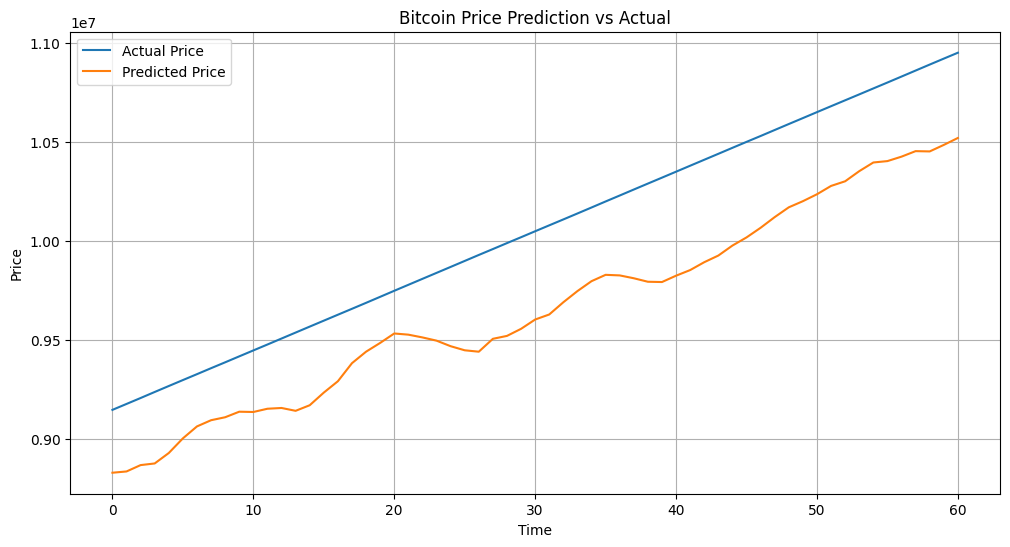

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step

Next Day Bitcoin price : 10534472.542213459


In [1]:
#Step 1:importing libreries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout
from textblob import TextBlob

#Step 2:Loading the bitcoin_price Dataset
price_df=pd.read_csv("bitcoin_price.csv")
price_df['Date']=pd.to_datetime(price_df['Date'])
price_df.set_index('Date',inplace=True)
price_data=price_df[['Close']]

#Step 3:Loading the bitcoim_tweet Dataset
tweet_df=pd.read_csv("btc_tweets.csv")
tweet_df['Date']=pd.to_datetime(tweet_df['Date'])
tweet_df.set_index('Date',inplace=True)

#Step 4:Genetating Daily Sentiment Score
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity
tweet_df['Sentiment']=tweet_df['Tweet'].apply(get_sentiment)
daily_sentiment=tweet_df[['Sentiment']].resample('D').mean().fillna(0)

#Step 5:Merge price and sentiment Data
combined_df=pd.concat([price_data,daily_sentiment],axis=1).fillna(method='ffill')
combined_df.columns=['Close','Sentiment']

#Step 6:Normalize data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(combined_df)  # Apply to both 'Close' and 'Sentiment'

#Step 7:Create Dataset for LSTM
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i])
        y.append(data[i, 0])  # Predicting 'Close'
    return np.array(X), np.array(y)

sequence_length = 60
X, y = create_sequences(scaled_data, sequence_length)
# Step 9: Train the model

train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


#Step 9:Building the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


#Step 10:Predict And Visualize Results
predicted = model.predict(X_test)

#Step 11:Combine with Sentimentcolum to inverse transform
# Extract actual sentiment values from the test part of the dataset
sentiment_col = scaled_data[sequence_length + train_size:, 1].reshape(-1, 1)

# Combine predicted close prices and sentiment for inverse transform
pred_combined = np.hstack((predicted, sentiment_col))
true_combined = np.hstack((y_test.reshape(-1, 1), sentiment_col))

# Inverse transform
predicted_prices = scaler.inverse_transform(pred_combined)[:, 0]
actual_prices = scaler.inverse_transform(true_combined)[:, 0]

#Step 12:Data Visualization
plt.figure(figsize=(12,6))
plt.plot(actual_prices, label="Actual Price")
plt.plot(predicted_prices, label="Predicted Price")
plt.title("Bitcoin Price Prediction vs Actual")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()

#Step 13:Predictt Next Day Price
last_sequence = scaled_data[-sequence_length:]
last_sequence = np.expand_dims(last_sequence, axis=0)
next_day_scaled = model.predict(last_sequence)

last_sentiment = scaled_data[-1, 1].reshape(1, 1)
next_day_combined = np.hstack((next_day_scaled, last_sentiment))
next_day_price = scaler.inverse_transform(next_day_combined)[0, 0]

print("\nNext Day Bitcoin price :", next_day_price)


In [ ]:
# Step 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from textblob import TextBlob

# Step 2: Load Bitcoin price data
price_df = pd.read_csv("bitcoin_price.csv")
price_df['Date'] = pd.to_datetime(price_df['Date'])
price_df.set_index('Date', inplace=True)
price_data = price_df[['Close']]

# Step 3: Load Tweet data
tweet_df = pd.read_csv("btc_tweets.csv")
tweet_df['Date'] = pd.to_datetime(tweet_df['Date'])
tweet_df.set_index('Date', inplace=True)

# Step 4: Sentiment analysis
tweet_df['Sentiment'] = tweet_df['Tweet'].apply(lambda text: TextBlob(text).sentiment.polarity)
daily_sentiment = tweet_df[['Sentiment']].resample('D').mean().fillna(0)

# Step 5: Merge price and sentiment data
combined_df = pd.concat([price_data, daily_sentiment], axis=1).fillna(method='ffill')

# Step 6: Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(combined_df)
